In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict,Counter
import matplotlib.pyplot as plt


In [2]:
DATA_DIR = 'data/amazon_des.pkl'
df = pd.read_pickle(DATA_DIR)

In [3]:
# df.categories = df.categories.apply(set)
df.head()

,categories,train/test,text
0000025240,"{criminology, politics & government, new, poli...",train,"Alan A. Block is emeritus professor of crime, ..."
0001004743,"{books, children's books, classics, literature...",train,Grade 4-8?The law of the jungle?intense compet...
0001024043,"{books, children's books, literature & fiction}",train,Trotter Street is alive with activity! Mae pre...
0001042335,"{new, english literature, books, literature, h...",train,William Shakespeare is widely regarded as the ...
0001046349,"{books, contemporary, literature & fiction}",train,"""No matter how appalling, malicious and preten..."


In [4]:
df['train/test'].value_counts()

train    1186239
test      306782
Name: train/test, dtype: int64

# Label distribution

In [6]:
# count +ve instances
labels = defaultdict(int)
for cats in df.categories:
    for cat in cats:
        labels[cat]+=1

In [7]:
l = sorted(zip(labels.values(),labels.keys()))

In [8]:
l[:10]

[(2, '& magic'),
 (2, '( i )'),
 (2, '1945 - present'),
 (2, 'a'),
 (2, 'a-d & d-a converters'),
 (2, 'abrasive collets'),
 (2, 'absorption sleeves'),
 (2, 'acapulco'),
 (2, 'acoustic guitar effects'),
 (2, 'acoustic guitar stands')]

In [9]:
l[-10:]

[(90254, 'new'),
 (90254, 'used & rental textbooks'),
 (94082, 'rock'),
 (96140, 'education & reference'),
 (111261, 'movies'),
 (122606, 'literature & fiction'),
 (150464, 'pop'),
 (160161, 'movies & tv'),
 (243575, 'music'),
 (446881, 'books')]

In [10]:
freqs = np.array(sorted(labels.values(),reverse = True))

Text(0.5, 1.0, 'High (~90.00%) P@1 can be achieved by predicting \nonly low (~10.00%) of classes correctly, ignoring tail labels')

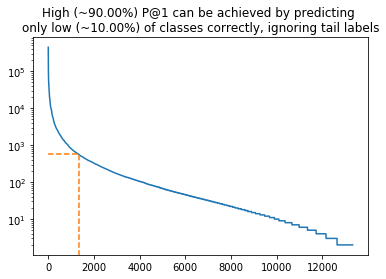

In [55]:
p = 90.00
yy = np.percentile(freqs,p)
xx = np.argmax(freqs<=yy)
plt.plot(freqs)
plt.plot([0,xx,xx],[yy,yy,0],'--')
plt.yscale('log')
plt.title('High (~{:.2f}%) P@1 can be achieved by predicting \nonly low (~{:.2f}%) of classes correctly, ignoring tail labels'.format(p,xx/len(freqs)*100))



# Label hiarachy

In [139]:
CAT_DIR = './Amazon_RawData/categories.txt'
CAT_MAP_DIR = "./AmazonCat-13K_mappings/AmazonCat-13K_label_map.txt"

In [140]:
# read categories
with open(CAT_MAP_DIR,'r',encoding = "ISO-8859-1") as f:
    cats_map = f.read().splitlines()
cats_set = set([c.lower() for c in cats_map])
with open(CAT_DIR,'r',encoding = "ISO-8859-1") as f:
    lines = f.read().splitlines()

In [142]:
# read categories (hierarchy)
with open(CAT_MAP_DIR,'r',encoding = "ISO-8859-1") as f:
    cats_map = f.read().splitlines()
cats_set = set([c.lower() for c in cats_map])
with open(CAT_DIR,'r',encoding = "ISO-8859-1") as f:
    lines = f.read().splitlines()
data = defaultdict(dict)
invalid = []
for i,line in enumerate(lines):
    if line[0]!=' ':
        id = line
        data[id]['categories']=[]
    elif line[:2]=='  ':
        cats = [t.strip().lower() for t in line.split(',')]
        cats = [c for c in cats if c in cats_set]
        if cats:
            data[id]['categories'].append(cats)
        else:
            invalid.append((i,line))
    else:
        raise Exception('invalide line {} : {}'.format(i,line))
print(set([line for i,line in invalid]))

{'  Amazon MP3 Store', '  ', '  Dance & DJ, Electronica', '  Dance & DJ, Trance'}


In [143]:
# only keep entries within train/test set
d = {key:data[key] for key in df.index.values}
data = d

In [144]:
# number of distinct hiarachy
h = [' > '.join(tag) for entry in data.values() for tag in entry['categories']]
print('No. of distinct hiarachy: {}'.format(len(set(h))))
print('No. of distinct lables  : {}'.format(len(labels)))

No. of distinct hiarachy: 19189
No. of distinct lables  : 12895


In [145]:
# depth of hiarachy
depths = [len(tag) for entry in data.values() for tag in entry['categories']]
depths = np.array(sorted(depths,reverse=True))
print('Depths: mean:{:.2f} min:{} max:{}'.format(np.mean(depths),np.min(depths),np.max(depths)))

Depths: mean:3.37 min:1 max:9


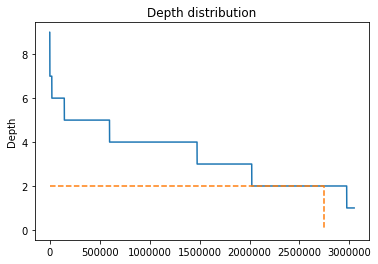

In [146]:
plt.plot(depths)
xx = .9*len(depths)
yy = depths[int(xx)]
plt.plot([0,xx,xx],[yy,yy,0],'--')
plt.title('Depth distribution')
plt.ylabel('Depth')
plt.show()

In [147]:
Counter(depths)

Counter({9: 53,
         8: 581,
         7: 19246,
         6: 125051,
         5: 452816,
         4: 876518,
         3: 547564,
         2: 950838,
         1: 74988})

90% of data has depth more than 1

## get hiarachy

In [21]:
from anytree.importer import DictImporter
from anytree.resolver import Resolver
from anytree import Node, RenderTree

In [22]:
def get_in(ll):
    if not ll:
        return []
    for i,l in enumerate(ll):
        ll[i]['children'] = get_in(list(l['children'].values()))
    return ll

In [23]:
class MyNode(Node):
    separator = ' > '

In [24]:
cats = [set() for _ in range(9)]
for entry in set(h):
    hh = entry.split(' > ')
    for i,t in enumerate(hh):
        cats[i].add(t)
print('Distinct classes in each layer:')
print([len(cat) for cat in cats])
cats = [set() for _ in range(9)]
for entry in set(h):
    hh = entry.split(' > ')
    for i,t in enumerate(hh):
        if i==0:
            cats[i].add(t)
        else:
            cats[i].add(' > '.join(hh[:i+1]))
print('Distinct hiarachy in each layer:')
print([len(cat) for cat in cats])

Distinct classes in each layer:
[45, 363, 2268, 6052, 5300, 1983, 440, 20, 2]
Distinct hiarachy in each layer:
[45, 383, 2715, 7809, 6713, 2326, 482, 21, 2]


In [25]:
nodes = {}
for entry in set(h):
    hh = entry.split(' > ')
    dd = nodes
    for i,t in enumerate(hh):
        if t not in dd.keys():
            dd[t]={'name':t,
                   'count':0,
                   'children':{}}
        dd = dd[t]['children']
ll = list(nodes.values())
ll = get_in(ll)

In [26]:
importer = DictImporter(MyNode)
trees = {l['name']:importer.import_(l) for l in ll}

In [27]:
# get count of each hiarachy
r = Resolver()
for entry in h:
    tt = entry.split(' > ')
    name = tt[0]
    path = ' > '.join(tt[1:])
    r.get(trees[name],path).count+=1

In [28]:
print(list(trees.keys()))

['arts', 'clothing & accessories', 'books', 'shoes', 'video games', 'home & kitchen', 'automotive', 'sports & outdoors', 'patio', 'pet supplies', 'magazine subscriptions', 'tools & home improvement', 'musical instruments', 'grocery & gourmet food', 'all electronics', 'toys & games', 'industrial & scientific', 'electronics', 'kindle store', 'health & personal care', 'beauty', 'office products', 'jewelry', 'music', 'baby products', 'cell phones & accessories', 'software', 'purchase circles', 'appliances', 'movies & tv', 'camera & photo', 'kitchen & dining', 'car electronics', 'watches', 'collectibles', 'office & school supplies', 'gift cards store', 'home improvement', 'baby', 'gps & navigation', 'mp3 players & accessories', 'furniture & d&#233;cor', 'miscellaneous', 'computers', 'amazon instant video']


In [56]:
print(RenderTree(trees['books']))

MyNode(' > books', count=33152)
├── MyNode(' > books > business & investing', count=2036)
│   ├── MyNode(' > books > business & investing > economics', count=763)
│   │   ├── MyNode(' > books > business & investing > economics > economic conditions', count=799)
│   │   ├── MyNode(' > books > business & investing > economics > public finance', count=80)
│   │   ├── MyNode(' > books > business & investing > economics > commerce', count=157)
│   │   ├── MyNode(' > books > business & investing > economics > comparative', count=42)
│   │   ├── MyNode(' > books > business & investing > economics > theory', count=597)
│   │   ├── MyNode(' > books > business & investing > economics > microeconomics', count=177)
│   │   ├── MyNode(' > books > business & investing > economics > free enterprise', count=138)
│   │   ├── MyNode(' > books > business & investing > economics > labor & industrial relations', count=475)
│   │   ├── MyNode(' > books > business & investing > economics > urban & regional',

distribution of each layer in tree

In [46]:
cats = [defaultdict(int) for _ in range(9)]
for entry in h:
    hh = entry.split(' > ')
    for i,t in enumerate(hh):
        if i==0:
            tt=t
        else:
            tt=' > '.join(hh[:i+1])
        cats[i][tt]+=1
print('Distinct hiarachy in each layer:')
print([len(cat) for cat in cats])

Distinct hiarachy in each layer:
[45, 383, 2715, 7809, 6713, 2326, 482, 21, 2]


In [31]:
def plot_bar(threshold,D,text=True):
    fig, ax = plt.subplots(figsize=(10, 10))
    dd = sorted(zip(D.values(),D.keys()))
    if len(dd)>threshold:
        a = threshold//2
        dd = dd[:a]+dd[-a:]
        plt.axhline(y=a-0.5,ls= '--')
    counts,labels = zip(*dd)
    plt.barh(range(len(counts)), counts, align='center')
    plt.yticks(range(len(labels)), labels)
    if text:
        for i,count in enumerate(counts):
            plt.text(count,i,str(count), color='blue')
    return fig,ax

In [47]:
for pre, fill, node in RenderTree(trees['books']):
    print("%s %s %s" % (pre, node.name,node.count))

 books 33152
├──  business & investing 2036
│   ├──  economics 763
│   │   ├──  economic conditions 799
│   │   ├──  public finance 80
│   │   ├──  commerce 157
│   │   ├──  comparative 42
│   │   ├──  theory 597
│   │   ├──  microeconomics 177
│   │   ├──  free enterprise 138
│   │   ├──  labor & industrial relations 475
│   │   ├──  urban & regional 40
│   │   ├──  environmental economics 705
│   │   ├──  econometrics 154
│   │   ├──  development & growth 550
│   │   ├──  economic history 547
│   │   ├──  macroeconomics 195
│   │   ├──  unemployment 116
│   │   ├──  money & monetary policy 160
│   │   └──  economic policy & development 390
│   ├──  job hunting & careers 80
│   │   ├──  job markets & advice 55
│   │   ├──  volunteer work 57
│   │   ├──  vocational guidance 297
│   │   ├──  interviewing 53
│   │   ├──  guides 1888
│   │   ├──  resumes 147
│   │   └──  job hunting 550
│   ├──  management & leadership 1246
│   │   ├──  negotiating 173
│   │   ├──  industrial 166
│   │   

│   │   ├──  21st century 411
│   │   ├──  18th century 1504
│   │   ├──  19th century 4366
│   │   ├──  20th century 7135
│   │   ├──  17th century 752
│   │   └──  16th century 613
│   ├──  medieval 1002
│   ├──  military science 2250
│   └──  renaissance 262
├──  humor & entertainment 3678
│   ├──  humor 1437
│   │   ├──  satire 1049
│   │   ├──  doctors & medicine 67
│   │   ├──  self-help & psychology 365
│   │   ├──  limericks & humorous verse 103
│   │   ├──  parenting & families 256
│   │   ├──  parodies 368
│   │   ├──  cooking 109
│   │   ├──  essays 625
│   │   ├──  urban legends 25
│   │   ├──  hunting & fishing 27
│   │   ├──  political 264
│   │   ├──  theories of humor 9
│   │   ├──  comedy 165
│   │   ├──  rural life 75
│   │   ├──  jokes & riddles 165
│   │   ├──  sports 103
│   │   ├──  cats 0
│   │   │   └──  dogs & animals 201
│   │   ├──  science & scientists 26
│   │   ├──  puns & wordplay 14
│   │   ├──  computers & internet 73
│   │   ├──  lawyers & criminals 12

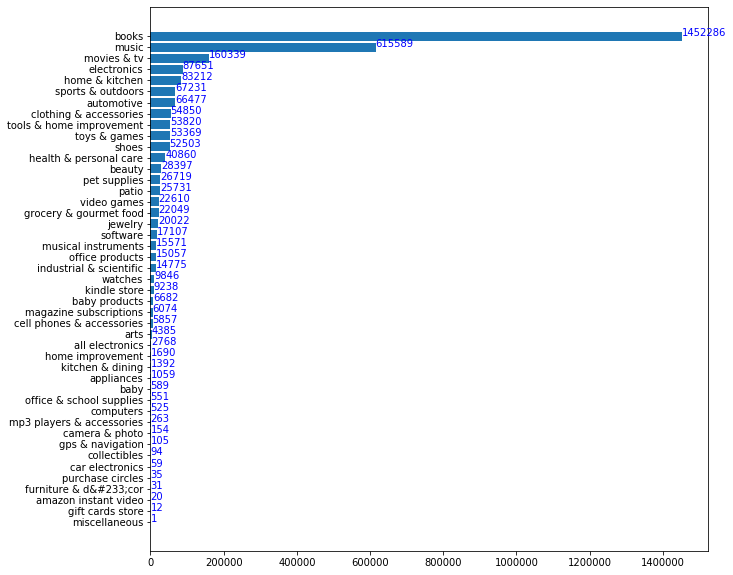

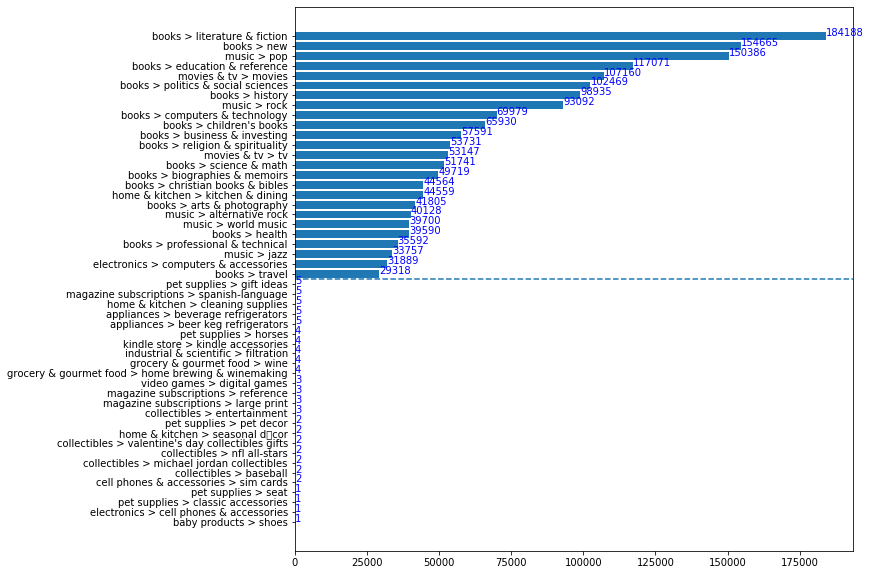

In [57]:
threshold = 50
for i in [0,1]:
    D = cats[i]
    ax = plot_bar(threshold,D,True)
    plt.show()

# output one hiarachy + text data

In [24]:
from tools.helper import clean_str

In [3]:
# read categories (hierarchy)
CAT_DIR = './Amazon_RawData/categories.txt'
CAT_MAP_DIR = "./AmazonCat-13K_mappings/AmazonCat-13K_label_map.txt"
with open(CAT_MAP_DIR,'r',encoding = "ISO-8859-1") as f:
    cats_map = f.read().splitlines()
cats_set = set([c.lower() for c in cats_map])
with open(CAT_DIR,'r',encoding = "ISO-8859-1") as f:
    lines = f.read().splitlines()
data = defaultdict(list)
invalid = []
for i,line in enumerate(lines):
    if line[0]!=' ':
        id = line
    elif line[:2]=='  ':
        cats = [t.strip().lower() for t in line.split(',')]
        cats = [c for c in cats if c in cats_set]
        if cats:
            data[id].append(cats)
        else:
            invalid.append((i,line))
    else:
        raise Exception('invalide line {} : {}'.format(i,line))
print(set([line for i,line in invalid]))

{'  Dance & DJ, Electronica', '  ', '  Amazon MP3 Store', '  Dance & DJ, Trance'}


In [4]:
data = {key:data[key] for key in df.index.values}

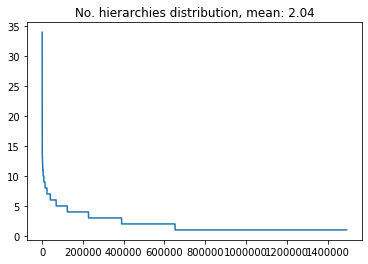

In [5]:
num_h = [len(d) for d in data.values()]
plt.plot(sorted(num_h,reverse=True))
plt.title('No. hierarchies distribution, mean: {:.2f}'.format(np.mean(num_h)))
plt.show()

In [6]:
# randomly chose one hierachy
optimal_depth = 0
one_h_data = defaultdict(list)
for id, texts in data.items():
    if len(texts) == 1:
        ind = 0
    else:
        length = min([max([len(text) for text in texts]),optimal_depth])
        texts = [text for text in texts if len(text)>=length]
        ind = np.random.randint(len(texts))
    one_h_data[id] = texts[ind]

In [7]:
# clip extreme depths 
q = int(np.percentile([len(x) for x in one_h_data.values()],95))
for key,val in one_h_data.items():
    i = int(min(len(val),q))
    one_h_data[key] = ' > '.join(val[:i])
print('clip depth to {}'.format(q))
df['categories'] = df.index.map(one_h_data)

clip depth to 5


In [38]:
# clean text
cleaned = {}
aa = len(df)
for i,(id,text) in enumerate(df['text'].iteritems()):
    cleaned[id] = clean_str(text)
    if i%(aa//100)==0:
        print()
        print('{:.2f}'.format(i/aa*100),end = ':')
    elif i%(aa//1000)==0:
        print('.',end = '')


0.00:.........
1.00:.........
2.00:.........
3.00:.........
4.00:.........
5.00:.........
6.00:.........
7.00:.........
8.00:.........
9.00:.........
10.00:.........
11.00:.........
12.00:.........
13.00:.........
14.00:.........
15.00:.........
16.00:.........
17.00:.........
18.00:.........
19.00:.........
20.00:.........
21.00:.........
22.00:.........
23.00:....

KeyboardInterrupt: 

In [40]:
import time  

In [54]:
# clean text
start = time.time()
for i,(id,text) in enumerate(df['text'].iteritems()):
    if id in cleaned.keys():
        continue
    cleaned[id] = clean_str(text)
    if i%(aa//100)==0:
        duration = time.time()-start
        print('{:02d}:{:02d}'.format(int(duration//60),int(duration%60)))
        print('COMPLETE {:.0f}% '.format(i/aa*100),end = '')
    elif i%(aa//1000)==0:
        print('.',end = '')

00:00
COMPLETE 31%:.........00:13
COMPLETE 32%:.........00:29
COMPLETE 33%:.........00:44
COMPLETE 34%:.........00:57
COMPLETE 35%:.........01:11
COMPLETE 36%:.........01:25
COMPLETE 37%:.........01:43
COMPLETE 38%:.........02:01
COMPLETE 39%:.........02:15
COMPLETE 40%:.........02:30
COMPLETE 41%:.........02:42
COMPLETE 42%:.........02:56
COMPLETE 43%:.........03:09
COMPLETE 44%:.........03:23
COMPLETE 45%:.........03:35
COMPLETE 46%:.........03:46
COMPLETE 47%:.........03:57
COMPLETE 48%:.........04:07
COMPLETE 49%:.........04:22
COMPLETE 50%:.........04:33
COMPLETE 51%:.........04:44
COMPLETE 52%:.........04:53
COMPLETE 53%:.........05:04
COMPLETE 54%:.........05:14
COMPLETE 55%:.........05:26
COMPLETE 56%:.........05:37
COMPLETE 57%:.........05:48
COMPLETE 58%:.........06:04
COMPLETE 59%:.........06:30
COMPLETE 60%:.........06:46
COMPLETE 61%:.........07:02
COMPLETE 62%:.........07:27
COMPLETE 63%:.........07:42
COMPLETE 64%:.........07:56
COMPLETE 65%:.........08:21
COMPLETE 66%:.

In [55]:
df['text'] = df.index.map(cleaned)

In [56]:
df.head()

,categories,train/test,text
0000025240,books > politics & social sciences > social sc...,train,alan a . block is emeritus professor of crime ...
0001004743,books > literature & fiction,train,grade 4-8 ? the law of the jungle ? intense co...
0001024043,books > children's books,train,trotter street is alive with activity ! mae pr...
0001042335,books > new > used & rental textbooks > humani...,train,william shakespeare is widely regarded as the ...
0001046349,books > literature & fiction > contemporary,train,"`` no matter how appalling , malicious and pre..."


In [57]:
# no newline in texts
aa = df.text.apply(lambda x: "\n" in x)
aa.value_counts()

False    1493021
Name: text, dtype: int64

In [58]:
df['train/test'].value_counts()

train    1186239
test      306782
Name: train/test, dtype: int64

In [59]:
# save dataset 
train_df = df[df['train/test']=='train']
test_df = df[df['train/test']=='test']
np.savetxt('data/amazon_1h/train_labels.txt',train_df['categories'],fmt='%s')
np.savetxt('data/amazon_1h/test_labels.txt',test_df['categories'],fmt='%s')
np.savetxt('data/amazon_1h/train_texts.txt',train_df['text'],fmt='%s')
np.savetxt('data/amazon_1h/test_texts.txt',test_df['text'],fmt='%s')

In [177]:
labels = set()
for ll in df['categories'].values:
    for l in ll.split('>'):
        labels.add(l.strip())
len(labels)

11591